In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/sushanbaniya/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host='localhost',
                            username='root',
                            password='12345',
                            database='ecommerce')

cur = db.cursor()

# listing all unique cities where customers are located

In [3]:
query = """ select distinct customer_city from customers """

cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# counting the number of orders placed in 2017

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)
data = cur.fetchall()
'total number of orders that was placed in the year 2017 is: ', data[0][0]

('total number of orders that was placed in the year 2017 is: ', 90202)

# finding the total sales per category

In [5]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales from
products join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by category
"""

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns=['Category', 'Sales'])
df

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,FASHION BAGS AND ACCESSORIES,1745266.24
4,BED TABLE BATH,13700429.37
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# calculating the percentage of orders that were paid in installments

In [6]:
query = """ select (((sum(case when payments.payment_installments >= 1 then 1 else 0 end)) / count(*)) * 100) from payments """

cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# counting the number of customers from each state

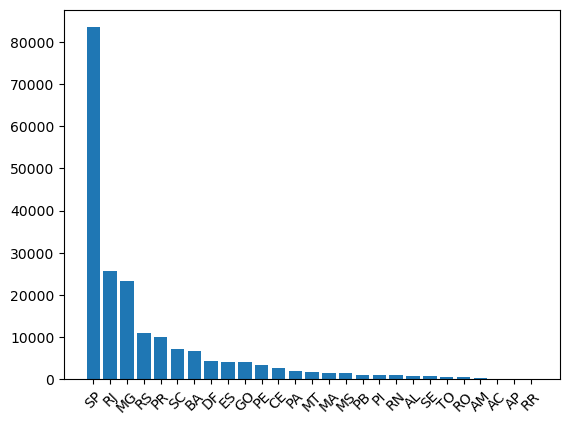

In [7]:
query = """ select customer_state, count(customer_id) from customers group by customer_state  """

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=['state', 'customer_count'])
df = df.sort_values(by='customer_count', ascending=False)

plt.bar(df['state'], df['customer_count'])
plt.xticks(rotation=45)
plt.show()

# calculating the numbers of order per month in 2018

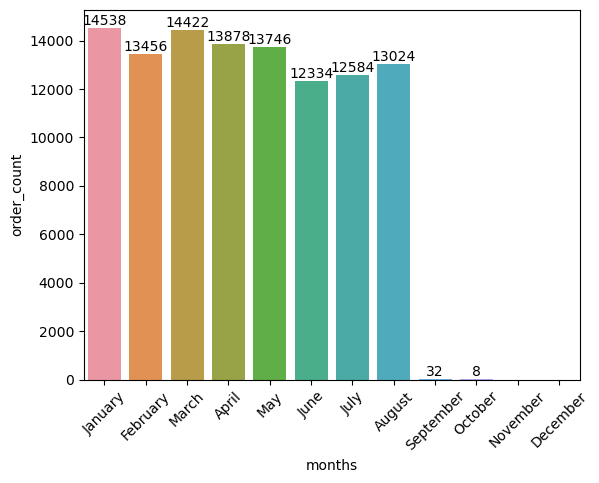

In [8]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count from orders where year(order_purchase_timestamp) = 2018 group by months """
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=['months','order_count'])
df
o = ['January','February','March','April','May','June','July','August','September','October','November','December']
# plt.figure(figsize=(4,15))
ax = sns.barplot(x=df['months'],y=df['order_count'], data=df, order=o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.show()

# finding the average number of products per order grouped by customer city

In [9]:
query = """ with count_per_order as ( select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id )

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders 
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=['Customer City','Average products per orders'])
df.head(10)

,Customer City,Average products per orders
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,picarra,16.00
7,morro de sao paulo,16.00
8,teixeira soares,16.00
9,curralinho,16.00


# calculating the percentage of total revenue contributed by each product category

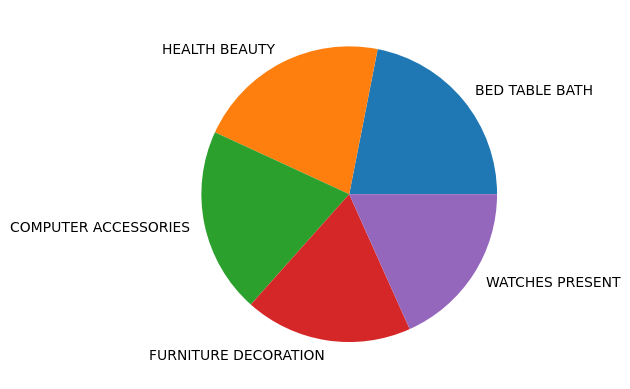

In [10]:
query = """select upper(products.product_category) category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage from
products join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by category
order by sales_percentage desc"""

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns=['Category', 'Percentage Revenue'])
df.head(10)

df = df.head(5)

plt.pie(df['Percentage Revenue'], labels=df['Category'])
plt.show()

# identify the correlation between product price and the number of times a product has been purchased

In [11]:
import numpy as np

query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=['Category','Order Count', 'Average Price'])
df.head()

arr1 = df['Order Count']
arr2 = df['Average Price']

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

 There is no significant correlation between Order Count and Price

# calculating the total revenue generated by each seller, and rank them by revenue

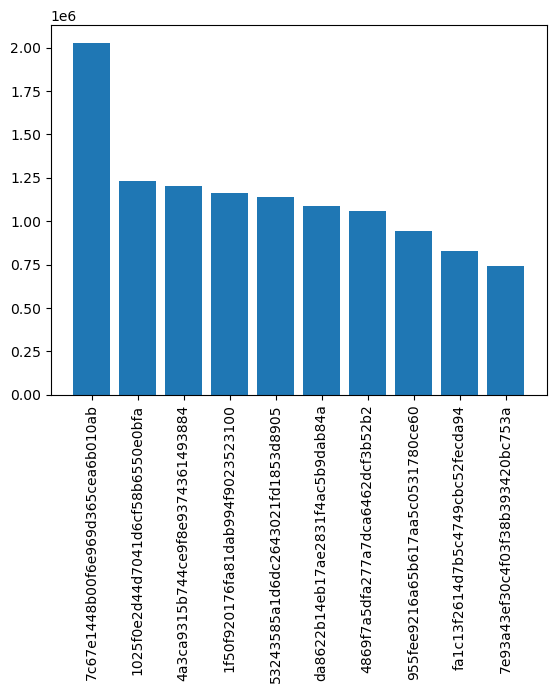

In [20]:
query = """select *, dense_rank() over(order by revenue desc) from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=['Seller id', 'Revenue', 'Rank'])
df
df = df.head(10)
ax = plt.bar(df['Seller id'], df['Revenue'])
plt.xticks(rotation=90)
plt.show()

# calculating the moving average of order values for each customer over their order history

In [23]:
query = """select customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row ) as moving_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment 
from orders join payments
on orders.order_id = payments.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=['Customer id', 'Order Purchase Timestamp', 'Payment Value', 'Moving Average of Payment Value'])
df

,Customer id,Order Purchase Timestamp,Payment Value,Moving Average of Payment Value
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# calculating the cumulative sales per month for each year

In [24]:
query = """select years, months, payment, sum(payment) 
over(order by years,months) cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years, 
month(orders.order_purchase_timestamp) as months, 
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years,months
order by years,months) as a;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# calculating the year-over-year growth rate of total sales

In [30]:
query = """with a as (select year(orders.order_purchase_timestamp) as years, 
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years
order by years)

select years, ((payment - lag(payment, 1) over(order by years))/lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns=['Year', 'Percentage growth year over year'])
df

,Year,Percentage growth year over year
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# calculating the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [31]:
query = """with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*((count(distinct a.customer_id))/(count(distinct b.customer_id)))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

In [32]:
print('No customers have purchased with 6 months of their first order')

No customers have purchased with 6 months of their first order


# identifying the top 3 customers who spent the most money in each year

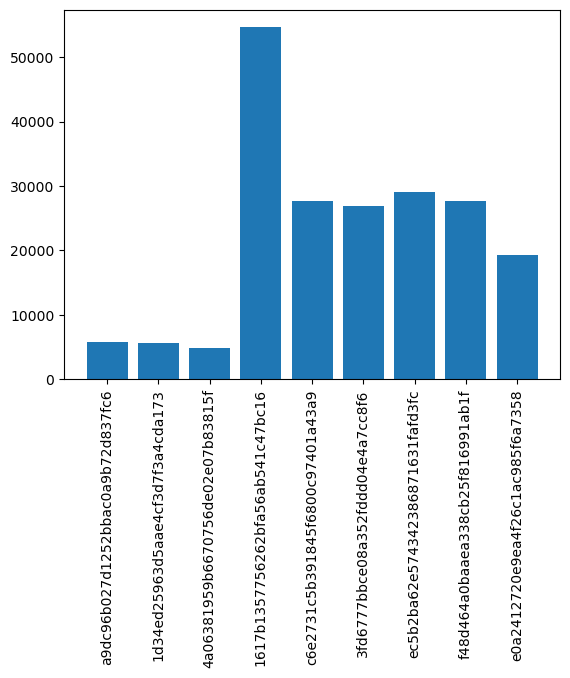

In [42]:
query = """select years, customer_id, payment, d_rank from
(select year(orders.order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value ) desc )  d_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()

data

df = pd.DataFrame(data, columns=['Years','Customer Id', 'Payments', 'Rank'])
df

plt.bar(df['Customer Id'], df['Payments'])
plt.xticks(rotation=90)
plt.show()